<a href="https://colab.research.google.com/github/BigOyayubi/PyTorchTutorial/blob/master/PyTorch1_1_GettingStarted_08_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://torch.classcat.com/2019/06/25/pytorch-1-1-getting-started-transfer-learning/

大抵の場合、十分なサイズのデータセットを用意できることは稀。

容易に準備できる非常に巨大なデータセットで（ImageNetなど）で事前訓練して、事前訓練結果を目的のタスクのための

*   初期化
*   固定した抽出器

として利用するのが一般的

本ノートブックは初期化に使う場合を試す。

初期化に使い訓練する際、最終結合層パラメータを一旦クリアする。

少ないデータセットで結合パラメータを再調整することを「FineTuning」という


#事前訓練済みNWでNWを初期化するハチ／アリ分類器

以下のような流れ

*   事前訓練済みNWをDLしNW初期化
*   NWを120訓練画像で訓練

事前訓練済みNWはResNet18を利用する。

ResNetはMicrosoft Reserch発のテクニックでこんな感じらしい。

このテクニックはより深いNWのトレーニングを可能にする。

![代替テキスト](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F203151%2Fb8fa1fa0-364f-8575-7ab8-6e79c9718d7d.png?ixlib=rb-1.2.2&auto=compress%2Cformat&gif-q=60&w=1400&fit=max&s=725f5b0de430d3868e436aa4acc17a68)



In [0]:

from __future__ import print_function, division
 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
 
plt.ion()   # interactive mode


In [0]:
#データダウンロード
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip -d data

--2019-09-26 08:48:10--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.255.47, 13.32.255.132, 13.32.255.114, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.255.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  13.8MB/s    in 3.4s    

2019-09-26 08:48:14 (13.1 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250.j

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

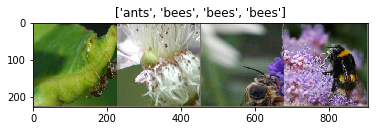

In [0]:
#DLした画像表示
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
 
 
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
 
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
 
imshow(out, title=[class_names[x] for x in classes])

In [0]:
#訓練を関数で実装
#schedulerはoptimizerのlr(学習率)の調整を行うオブジェクト
#関数内ループで学習結果が良ければ、modelのパラメータ(state_dict)を更新する
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
 
            running_loss = 0.0
            running_corrects = 0
 
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                # zero the parameter gradients
                optimizer.zero_grad()
 
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
 
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
 
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
 
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        print()
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#少数の画像の判定結果を表示する
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
 
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
 
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
#事前訓練済みのResNetをロードする
model_ft = models.resnet18(pretrained=True)
#最後の完全結合層をリセット
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
#GPU向けに 
model_ft = model_ft.to(device)
#損失関数：交差エントロピー
criterion = nn.CrossEntropyLoss()
# 最適化関数 Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# 最適化関数に対応したスケジューラー
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 51402407.08it/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5221 Acc: 0.7172
val Loss: 0.3145 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5639 Acc: 0.7623
val Loss: 0.2624 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4644 Acc: 0.7992
val Loss: 0.2968 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.3263 Acc: 0.8893
val Loss: 0.1543 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5042 Acc: 0.7869
val Loss: 0.2644 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3547 Acc: 0.8320
val Loss: 0.2388 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3574 Acc: 0.8484
val Loss: 0.2088 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2843 Acc: 0.8852
val Loss: 0.1969 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3068 Acc: 0.8770
val Loss: 0.1919 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3459 Acc: 0.8320
val Loss: 0.2650 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2669 Acc: 0.8893
val Loss: 0.1708 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3013 Acc: 0.8730
val Loss: 0.1577 Acc: 0.9346

Ep